In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = datasets.CIFAR10(root='./data',\
              train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
                                batch_size=32, shuffle=True)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


In [4]:
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [7]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))

Epoch [1/10]                        Batch 100/1563 Discriminator Loss: 0.4233 Generator Loss: 1.6747
Epoch [1/10]                        Batch 200/1563 Discriminator Loss: 0.5834 Generator Loss: 1.1600
Epoch [1/10]                        Batch 300/1563 Discriminator Loss: 0.5738 Generator Loss: 1.4049
Epoch [1/10]                        Batch 400/1563 Discriminator Loss: 0.6573 Generator Loss: 1.0335
Epoch [1/10]                        Batch 500/1563 Discriminator Loss: 0.5987 Generator Loss: 1.2280
Epoch [1/10]                        Batch 600/1563 Discriminator Loss: 0.5817 Generator Loss: 1.2422
Epoch [1/10]                        Batch 700/1563 Discriminator Loss: 0.5608 Generator Loss: 1.1288
Epoch [1/10]                        Batch 800/1563 Discriminator Loss: 0.6478 Generator Loss: 0.8067
Epoch [1/10]                        Batch 900/1563 Discriminator Loss: 0.6920 Generator Loss: 1.3863
Epoch [1/10]                        Batch 1000/1563 Discriminator Loss: 0.5795 Generator Lo

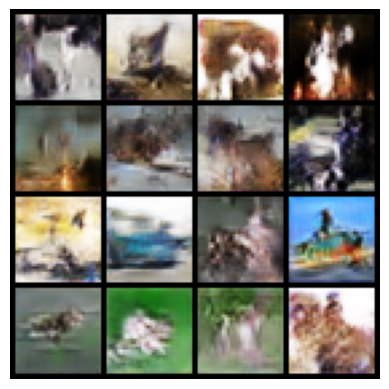

In [8]:
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):

        real_images = batch[0].to(device)

        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        real_images = real_images.to(device)

        optimizer_D.zero_grad()

        z = torch.randn(real_images.size(0), latent_dim, device=device)

        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator\
                                     (real_images), valid)
        fake_loss = adversarial_loss(discriminator\
                                     (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        gen_images = generator(z)

        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset & Dataloader
train_dataset = datasets.CIFAR10(root='./data',
                                 train=True,
                                 download=True,
                                 transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=32,
                                         shuffle=True)

# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10

# -------------------------
# Generator
# -------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

# -------------------------
# Discriminator
# -------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Losses
adversarial_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# -------------------------
# Training Loop
# -------------------------
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):

        real_images = batch[0].to(device)

        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Generate fake images
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)

        # Discriminator loss on real and fake
        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        gen_images = generator(z)

        # Adversarial loss (want D to classify fake as real)
        g_adv_loss = adversarial_loss(discriminator(gen_images), valid)

        # Reconstruction MSE loss with respect to real images
        g_mse_loss = mse_loss(gen_images, real_images[:gen_images.size(0)])

        # Total Generator loss
        g_loss = g_adv_loss + 0.5 * g_mse_loss

        g_loss.backward()
        optimizer_G.step()

        # Print progress
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {i+1}/{len(dataloader)} "
                f"D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} "
                f"(Adv: {g_adv_loss.item():.4f}, MSE: {g_mse_loss.item():.4f})"
            )

    # Generate samples after each epoch
    with torch.no_grad():
        z = torch.randn(16, latent_dim, device=device)
        generated = generator(z).detach().cpu()
        grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis("off")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

Training Simple GAN (Before MSE)...
Training GAN with MSE...

Comparison Table (Before vs After MSE):
    Epoch  Batch    D Loss    D Acc    G Loss  Adv Loss  \
0       1    500  0.661123  62.5000  0.876355  0.876355   
1       1   1000  0.612589  84.3750  0.968287  0.968287   
2       1   1500  0.589408  76.5625  1.140028  1.140028   
3       2    500  0.813424  68.7500  0.799699  0.799699   
4       2   1000  0.528691  85.9375  0.979830  0.979830   
5       2   1500  0.542907  81.2500  1.146680  1.146680   
6       3    500  0.565545  84.3750  1.286798  1.286798   
7       3   1000  0.685324  56.2500  0.722592  0.722592   
8       3   1500  0.570886  79.6875  0.782600  0.782600   
9       4    500  0.546517  71.8750  1.587006  1.587006   
10      4   1000  0.607961  75.0000  0.850110  0.850110   
11      4   1500  0.519239  85.9375  1.094783  1.094783   
12      5    500  0.837281  68.7500  1.101614  1.101614   
13      5   1000  0.641127  64.0625  0.640185  0.640185   
14      5   1

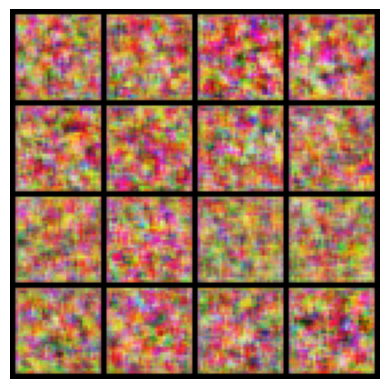

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset & DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1, beta2 = 0.5, 0.999
num_epochs = 5   # keep small for testing; increase later

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        return self.model(img)

# Losses
adversarial_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

# Function to train GAN
def train_gan(use_mse=False):
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

    history = []

    for epoch in range(num_epochs):
        for i, batch in enumerate(dataloader):
            real_images = batch[0].to(device)
            valid = torch.ones(real_images.size(0), 1, device=device)
            fake = torch.zeros(real_images.size(0), 1, device=device)

            # Train Discriminator
            optimizer_D.zero_grad()
            z = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = generator(z)

            real_loss = adversarial_loss(discriminator(real_images), valid)
            fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Discriminator accuracy
            real_acc = (discriminator(real_images) > 0.5).float().mean().item()
            fake_acc = (discriminator(fake_images.detach()) < 0.5).float().mean().item()
            d_acc = 0.5 * (real_acc + fake_acc)

            # Train Generator
            optimizer_G.zero_grad()
            gen_images = generator(z)
            adv_loss = adversarial_loss(discriminator(gen_images), valid)

            mse_val = 0.0
            if use_mse:
                mse_val = mse_loss(gen_images, real_images)
                g_loss = adv_loss + mse_val
            else:
                g_loss = adv_loss

            g_loss.backward()
            optimizer_G.step()

            if (i+1) % 500 == 0:  # log periodically
                history.append({
                    "Epoch": epoch+1,
                    "Batch": i+1,
                    "D Loss": d_loss.item(),
                    "D Acc": d_acc*100,
                    "G Loss": g_loss.item(),
                    "Adv Loss": adv_loss.item(),
                    "MSE Loss": mse_val if use_mse else 0
                })
    return history

# Train GAN before and after MSE
print("Training Simple GAN (Before MSE)...")
history_before = train_gan(use_mse=False)

print("Training GAN with MSE...")
history_after = train_gan(use_mse=True)

# Convert to DataFrame for comparison
df_before = pd.DataFrame(history_before)
df_after = pd.DataFrame(history_after)

# Merge results for comparison
comparison = pd.concat([
    df_before.assign(Mode="Before MSE"),
    df_after.assign(Mode="After MSE")
])

print("\nComparison Table (Before vs After MSE):")
print(comparison.head(20))

# Show example generated images after MSE training
with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)
    generator = Generator(latent_dim).to(device)
    gen_imgs = generator(z).detach().cpu()
    grid = torchvision.utils.make_grid(gen_imgs, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.axis("off")
    plt.show()
